In [96]:
library(glmnet)
library(mvtnorm)
library(repr)
library(ggplot2)
library(reshape2)

Warning message:
"package 'reshape2' was built under R version 3.6.1"

# Problem Set 4

## Exercise 1

Consider the following DGP:

* $n$ observations and $p$ predictors; initially set $p=50$
* $\mathbf{X}\sim \mathcal{N}_p(\mathbf{0}, \mathbf{\Sigma})$, where $\Sigma$ is diagonal and the variances range from $1$ to $2$.
* The population coefficients $\beta$ range from $0.1 \sim 0.5$. You can sample values or use eqi-spaced values.
* $\epsilon \sim N(0, 1)$

In [2]:
# Data generating #

# Parameters
N <- 1000
p <- 50

# Generate data.
generate_data <- function(sam_size, pre_size){
    # Generate X.
    mu <- rep(0, times=pre_size)
    sig.seq <- runif(pre_size, 1, 2)
    sigma <- diag(x=sig.seq)
    X <- rmvnorm(sam_size, mu, sigma)

    # Generate beta and error terms.
    beta <- runif(pre_size, 0.1, 0.5)
    err <- rnorm(sam_size, 0, 1)

    # Generate responses.
    y = X %*% beta + err
    
    list_data = list(y, X)
    names(list_data) <- c('y', 'X')
    
    return(list_data)
}

data <- generate_data(N, p)

**a)** Implement the ridge regression estimator and the lasso estimator using `glmnet` for a grid of different
penalty parameters.

**b)** Draw a test data set and plot the test error for the different values of $\lambda$

In [3]:
# Draw training data and test data.
# Resampling strategy: random sample,
# training_size:test_size = 7:3
trte.ratio <- 7 / 10
X <- data$X
y <- data$y

tr.idx <- sample(1:nrow(X), N * trte.ratio)
te.idx <- -tr.idx
X.train <- X[tr.idx,]
y.train <- y[tr.idx]
X.test <- X[te.idx,]
y.test <- y[te.idx]

In [4]:
# Set the regularization path.
grid = 10 ^ seq(10, -2, length=100)
#grid <- seq(0, 1, 0.01)

# Implement Ridge regression and plot the test error.
ridge.mod <- glmnet(X.train, y.train, alpha=0, lambda=grid)
ridge.pre <- predict(ridge.mod, s=grid, newx=X.test)
ridge.mse <- colMeans((ridge.pre - y.test) ^ 2)
#plot(log(grid), ridge.mse, type='l')
ridge.df <- data.frame(log(grid), ridge.mse)

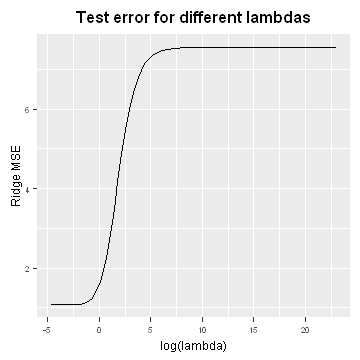

In [70]:
options(repr.plot.width=3, repr.plot.height=3)
p <- ggplot(aes(x=log.grid., y=ridge.mse), data=ridge.df)+ geom_line()
p <- p + labs(title='Test error for different lambdas', x='log(lambda)', y='Ridge MSE', cex=0.5)
p <- p + theme(plot.title = element_text(hjust = 0.5))
p + theme(axis.text=element_text(size=5), axis.title=element_text(size=7, face='plain'), title=element_text(size=8, face='bold'))

In [72]:
# Implement Lasso regression and plot the test error.
lasso.mod = glmnet(X.train, y.train, alpha=1, lambda=grid)
lasso.pre = predict(lasso.mod, s=grid, newx=X.test)
lasso.mse = colMeans((lasso.pre - y.test) ^ 2)
#plot(log(grid), lasso.mse, type='l')
lasso.df <- data.frame(log(grid), lasso.mse)

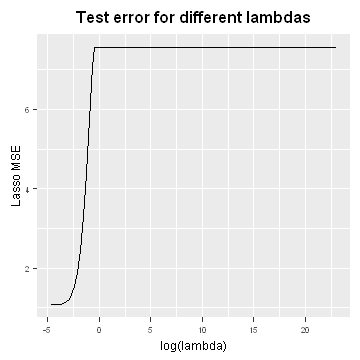

In [73]:
options(repr.plot.width=3, repr.plot.height=3)
p <- ggplot(aes(x=log.grid., y=lasso.mse), data=lasso.df)+ geom_line()
p <- p + labs(title='Test error for different lambdas', x='log(lambda)', y='Lasso MSE', cex=0.5)
p <- p + theme(plot.title = element_text(hjust = 0.5))
p + theme(axis.text=element_text(size=5), axis.title=element_text(size=7, face='plain'), title=element_text(size=8, face='bold'))

**c)** Choose the optimal $\lambda$ using the build in cross-validation function from glmnet and calculate the mean
squared test error drawing a new test data set and compare Ridge regression, Lasso and OLS.

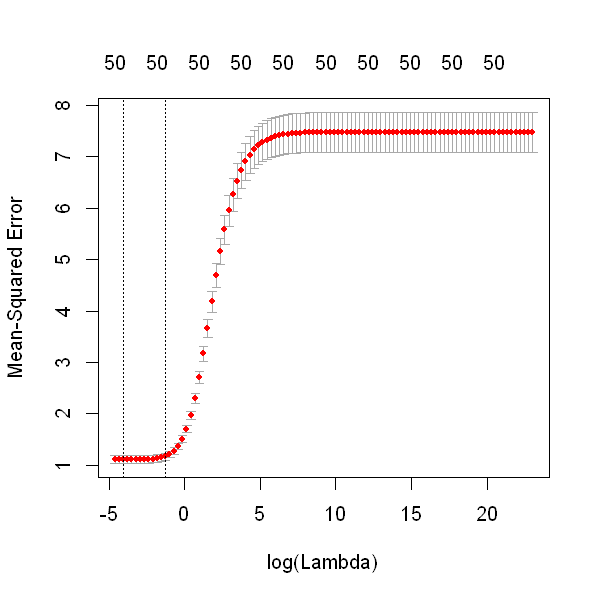

In [75]:
# Choose optimal lambda for Ridge.
cv.ridge <- cv.glmnet(X.train, y.train, alpha=0, lambda=grid)
opt.ridge <- cv.ridge$lambda.min
options(repr.plot.width=5, repr.plot.height=5)
plot(cv.ridge)

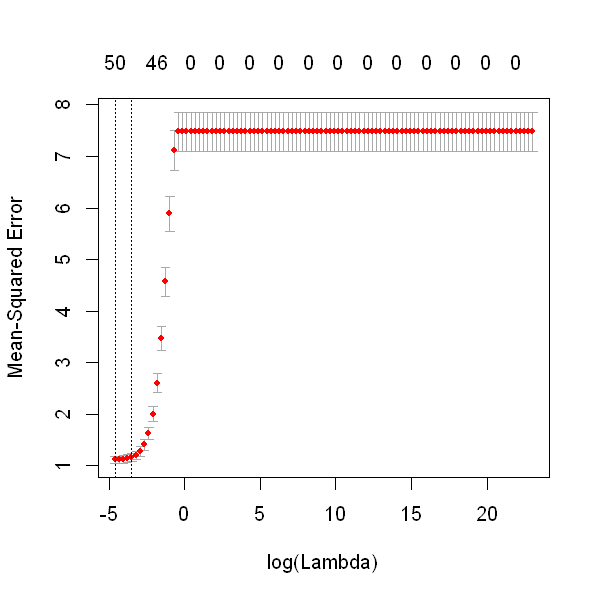

In [76]:
# Choose optimal lambda for Lasso.
cv.lasso <- cv.glmnet(X.train, y.train, alpha=1, lambda=grid)
opt.lasso <- cv.lasso$lambda.min
options(repr.plot.width=5, repr.plot.height=5)
plot(cv.lasso)

In [9]:
# New Dataset: train and test separate.
test2 <- generate_data(N, p)

X.test2 <- test2$X
y.test2 <- test2$y

# Ridge MSE.
ridge2.pred <- predict(ridge.mod, s=opt.ridge, newx=X.test2)
ridge2.mse <- mean((ridge2.pred - y.test2) ^ 2)

# Lasso MSE
lasso2.pred <- predict(lasso.mod, s=opt.lasso, newx=X.test2)
lasso2.mse <- mean((lasso2.pred - y.test2) ^ 2)

# OLS MSE
train_dat <- cbind(y, X)
test_data2 <- cbind(y.test2, X.test2)
newdata2 <- rbind(train_dat, test_data2)

newdata2 <- as.data.frame(newdata2)
names(newdata2)[1] <- 'y'

ols2 <- lm(y~., data=newdata2[1:1000,])
ols2.pred <- predict(ols2, newdata=newdata2[1001:2000,])
ols2.mse <- mean((ols2.pred - y.test2)^2)

In [13]:
ols2.mse
ridge2.mse
lasso2.mse

[1] 2.621431

[1] 2.600498

[1] 2.621614

### A dangerous bug here:

This bug occurs when using the arg `newdata=` of `predict.lm()` function:

If we estimate in ols using the original data `X` and `y` as our training data:

In [14]:
ols.exp <- lm(y~X, data=data)

Now take the `newdata2[1001:2000,]` as our test data:

In [15]:
ols.pred.exp <- predict(ols.exp, newdata=newdata2[1001:2000,])

There will be a very large MSE:

In [16]:
ols.mse.exp <- mean((ols.pred.exp - y.test2)^2)
ols.mse.exp

[1] 14.80364

The reason why this case arises is the inconsistency of the column names between `data` and `newdata2`. Actually the function `predict()` will attempt to match the column names in `data` but there is only `y` in common and the predictor part is empty. Hence by default it will use the training predictors in the `data` rather than the test predictors in the `newdata2`, which means that it calculates the MSE of new test responses and old predictors, which also leads to a very large error.

To verify this, we calculate the error as following:

In [17]:
X2 <- cbind(rep(1, 1000), X)

In [18]:
X.test22 <- cbind(rep(1, 1000), X.test2)

In [19]:
mean((t(y.test2) - t(as.matrix(ols2$coef)) %*% t(X2))^2)

[1] 14.80364

We get the same result as before. Now we turn to use `test_exp`, which has the same list item name as `data`, and this time we expect to have a smaller MSE (test error):

In [20]:
ols.pred.exp <- predict(ols.exp, newdata=test2)
ols.mse.exp <- mean((ols.pred.exp - y.test2)^2)
ols.mse.exp

[1] 2.621431

The MSE (training error) is much lower:

In [21]:
ols.pred.exp <- predict(ols.exp, newdata=data)
ols.mse.exp <- mean((ols.pred.exp - y)^2)
ols.mse.exp

[1] 0.9582021

Anyway, be careful of the correspondence between column names.

## Exercise 2

Evaluate the difference in prediction performance of the lasso and ridge regression and OLS by

**a)** increasing the number of predictors (generated by the same rules as outlined above)

In [22]:
# We simulate more observations.
N <- 2000

# Candidate predictor sizes.
num_p <- seq(10, 800, by=80)

# Prepare for recording MSE.
mses.ridge21 <- rep(NA, times=length(num_p))
mses.lasso21 <- rep(NA, times=length(num_p))
mses.ols21 <- rep(NA, times=length(num_p))

# Loop for number of predictos.
for(i in 1:length(num_p)){
    # Select training and test samples.
    data2 <- generate_data(N, num_p[i])

    trte.ratio <- 0.5
    X2 <- data2$X
    y2 <- data2$y

    tr.idx <- sample(1:nrow(X2), N * trte.ratio)
    te.idx <- -tr.idx
    X2.train <- X2[tr.idx,]
    y2.train <- y2[tr.idx]
    X2.test <- X2[te.idx,]
    y2.test <- y2[te.idx]

    # Integrate the rearanged datasets into a dataframe.
    data2_ra <- as.data.frame(rbind(cbind(y2.train, X2.train), cbind(y2.test, X2.test)))
    names(data2_ra)[1] <- 'y2'

    # Ridge MSE.
    cv.ridge21 <- cv.glmnet(X2.train, y2.train, alpha=0, lambda=grid)
    opt.ridge21 <- cv.ridge21$lambda.min
    ridge21.mod <- glmnet(X2.train, y2.train, alpha=0, lambda=grid)
    ridge21.pred <- predict(ridge21.mod, s=opt.ridge21, newx=X2.test)
    ridge21.mse <- mean((ridge21.pred - y2.test) ^ 2)
    mses.ridge21[i] <- ridge21.mse

    # Lasso MSE.
    cv.lasso21 <- cv.glmnet(X2.train, y2.train, alpha=1, lambda=grid)
    opt.lasso21 <- cv.lasso21$lambda.min
    lasso21.mod <- glmnet(X2.train, y2.train, alpha=1, lambda=grid)
    lasso21.pred <- predict(lasso21.mod, s=opt.lasso21, newx=X2.test)
    lasso21.mse <- mean((lasso21.pred - y2.test) ^ 2)
    mses.lasso21[i] <- lasso21.mse

    # OLS MSE
    ols21 <- lm(y2~., data=data2_ra[1:1000,])
    ols21.pred <- predict(ols21, newdata=data2_ra[1001:2000,])
    ols21.mse <- mean((ols21.pred - y2.test)^2)
    mses.ols21[i] <- ols21.mse    
}

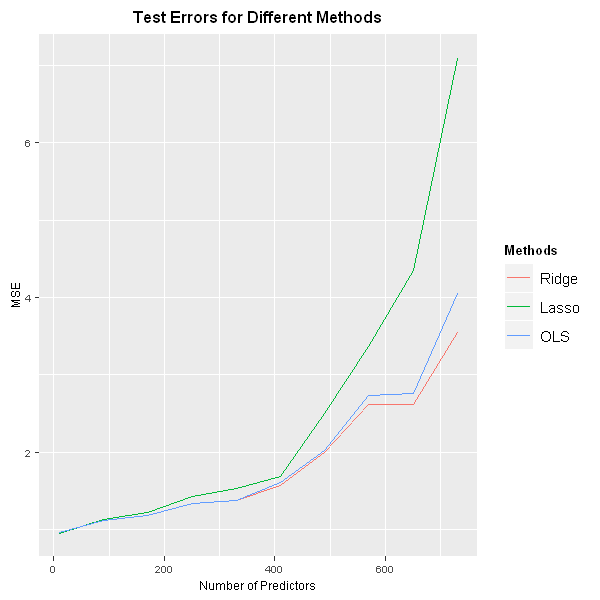

In [113]:
# Prepare the data.frame for plot.
df21 <- data.frame(num_p, mses.ridge21, mses.lasso21, mses.ols21)
colnames(df21)[2:4] <- c('Ridge', 'Lasso', 'OLS')
df21.mt <- melt(df21, id.vars='num_p', variable.name='Methods')

# Plot
options(repr.plot.width=5, repr.plot.height=5)
p <- ggplot(aes(x=num_p, y=value), data=df21.mt) + geom_line(aes(colour=Methods))
p <- p + labs(title='Test Errors for Different Methods', x='Number of Predictors', y='MSE', cex=0.5)
p <- p + theme(plot.title = element_text(hjust = 0.5))
p <- p + theme(axis.text=element_text(size=6), axis.title=element_text(size=7, face='plain'), title=element_text(size=8, face='bold'))
p + scale_fill_discrete(labels=c("Ridge", "Lasso", "OLS"))
# plot(num_p, mses.ridge21, type='l', xlab='Number of Predictors', ylab='MSE (Test Error)')
# lines(num_p, mses.lasso21, col='red')
# lines(num_p, mses.ols21, col='blue')
# legend(1, 1.9, legend=c('ridge', 'lasso', 'ols'),lty=1:1:1,
#       col=c('black', 'red', 'blue'))

This result violates the non-increasing relation between the MSE and the number of regressors. This is because we did not use the whole dataset as the training set, but split the data into two parts evenly and took one of them as the training set. In this split case, we can make a statistical prediction claims about the test data. If we take the whole data as the training set, we can verify that the relation is non-increasing (actually, decreasing). However, we cannot give any claims on the test data because there is no longer test dataset!

In [24]:
# Prepare for recording MSE.
mses.ridge21.w <- rep(NA, times=length(num_p))
mses.lasso21.w <- rep(NA, times=length(num_p))
mses.ols21.w <- rep(NA, times=length(num_p))

# Loop for number of predictos.
for(i in 1:length(num_p)){
    # Select training and test samples.
    data2.w <- generate_data(N, num_p[i])

    trte.ratio <- 0.5
    X2.w <- data2$X
    y2.w <- data2$y

    tr.idx <- sample(1:nrow(X2.w), N * trte.ratio)
    te.idx <- -tr.idx
    X2.test.w <- X2.w[te.idx,]
    y2.test.w <- y2.w[te.idx]
    
    df2.w <- data.frame(y2.w, X2.w)

    # Ridge MSE.
    cv.ridge21.w <- cv.glmnet(X2.w, y2.w, alpha=0, lambda=grid)
    opt.ridge21.w <- cv.ridge21.w$lambda.min
    ridge21.mod.w <- glmnet(X2.w, y2.w, alpha=0, lambda=grid)
    ridge21.pred.w <- predict(ridge21.mod.w, s=opt.ridge21.w, newx=X2.test.w)
    ridge21.mse.w <- mean((ridge21.pred.w - y2.test.w) ^ 2)
    mses.ridge21.w[i] <- ridge21.mse.w

    # Lasso MSE.
    cv.lasso21.w <- cv.glmnet(X2.w, y2.w, alpha=1, lambda=grid)
    opt.lasso21.w <- cv.lasso21.w$lambda.min
    lasso21.mod.w <- glmnet(X2.w, y2.w, alpha=1, lambda=grid)
    lasso21.pred.w <- predict(lasso21.mod.w, s=opt.lasso21.w, newx=X2.test.w)
    lasso21.mse.w <- mean((lasso21.pred.w - y2.test.w) ^ 2)
    mses.lasso21.w[i] <- lasso21.mse.w

    # OLS MSE
    ols21.w <- lm(y2.w~., data=df2.w)
    ols21.pred.w <- predict(ols21.w, newdata=df2.w[te.idx,])
    ols21.mse.w <- mean((ols21.pred.w - y2.test.w)^2)
    mses.ols21.w[i] <- ols21.mse.w 
}

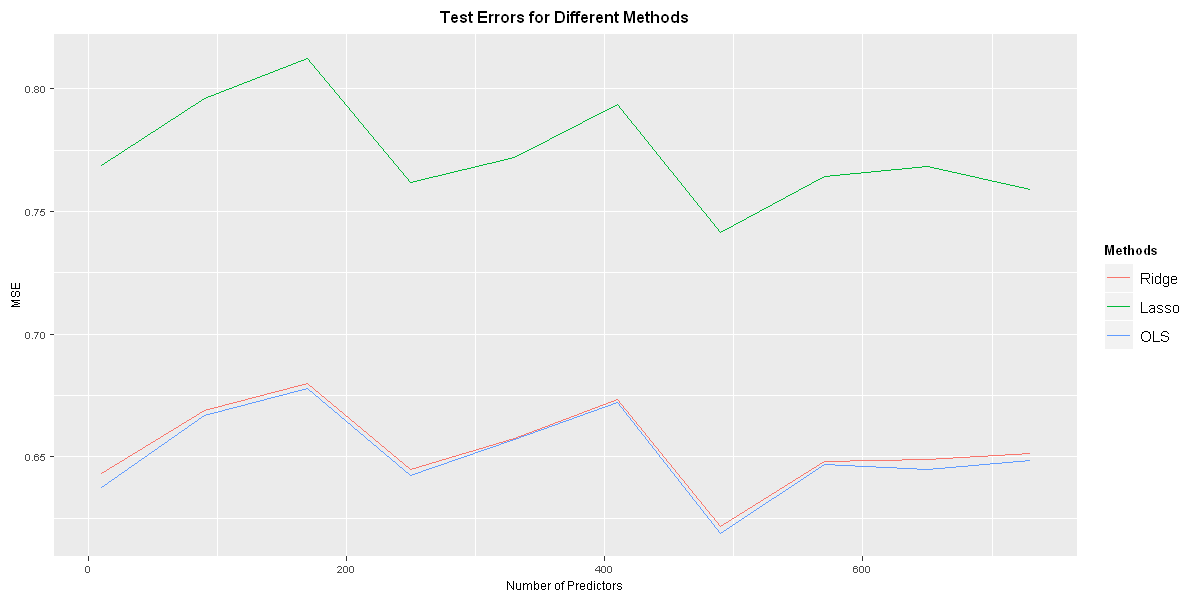

In [124]:
# Prepare the data.frame for plot.
df21.w <- data.frame(num_p, mses.ridge21.w, mses.lasso21.w, mses.ols21.w)
colnames(df21.w)[2:4] <- c('Ridge', 'Lasso', 'OLS')
df21.w.mt <- melt(df21.w, id.vars='num_p', variable.name='Methods')

# Plot
options(repr.plot.width=10, repr.plot.height=5)
p <- ggplot(aes(x=num_p, y=value), data=df21.w.mt) + geom_line(aes(colour=Methods))
p <- p + labs(title='Test Errors for Different Methods', x='Number of Predictors', y='MSE', cex=0.5)
p <- p + theme(plot.title = element_text(hjust = 0.5))
p <- p + theme(axis.text=element_text(size=6), axis.title=element_text(size=7, face='plain'), title=element_text(size=8, face='bold'))
p + scale_fill_discrete(labels=c("Ridge", "Lasso", "OLS"))
# plot(num_p, mses.ridge21.w, type='l', xlab='Number of Predictors', ylab='MSE', ylim=c(0.55, 0.8))
# lines(num_p, mses.lasso21.w, col='red')
# lines(num_p, mses.ols21.w, col='blue')
# legend(50, 0.6, legend=c('ridge', 'lasso', 'ols'),lty=1:1:1,
#       col=c('black', 'red', 'blue'))

**b)** Increasing the degree of sparsity in $\beta$ (while keeping the number of predictors fixed).

In [26]:
# Increase the sparsity in beta.
beta_upper <- seq(0.5, 1, length.out=50)

# New data generating function.
generate_data22 <- function(sam_size, pre_size, b_upper){
    # Generate X.
    mu <- rep(0, times=pre_size)
    sig.seq <- runif(pre_size, 1, 2)
    sigma <- diag(x=sig.seq)
    X <- rmvnorm(sam_size, mu, sigma)

    # Generate beta and error terms.
    beta <- runif(pre_size, 0.1, b_upper)
    err <- rnorm(sam_size, 0, 1)

    # Generate responses.
    y = X %*% beta + err
    
    list_data = list(y, X)
    names(list_data) <- c('y', 'X')
    
    return(list_data)
}

In [27]:
# Fix p = 50.
N <- 2000
p <- 50

# Prepare for recording MSE.
mses.ridge22 <- rep(NA, times=length(beta_upper))
mses.lasso22 <- rep(NA, times=length(beta_upper))
mses.ols22 <- rep(NA, times=length(beta_upper))

# Loop for number of predictos.
for(i in 1:length(beta_upper)){
    # Select training and test samples.
    data22 <- generate_data22(N, p, beta_upper[i])

    trte.ratio <- 0.5
    X22 <- data22$X
    y22 <- data22$y

    tr.idx <- sample(1:nrow(X22), N * trte.ratio)
    te.idx <- -tr.idx
    X22.train <- X22[tr.idx,]
    y22.train <- y22[tr.idx]
    X22.test <- X22[te.idx,]
    y22.test <- y22[te.idx]

    # Integrate the rearanged datasets into a dataframe.
    data22_ra <- as.data.frame(rbind(cbind(y22.train, X22.train), cbind(y22.test, X22.test)))
    names(data22_ra)[1] <- 'y22'

    # Ridge MSE.
    cv.ridge22 <- cv.glmnet(X22.train, y22.train, alpha=0, lambda=grid)
    opt.ridge22 <- cv.ridge22$lambda.min
    ridge22.mod <- glmnet(X22.train, y22.train, alpha=0, lambda=grid)
    ridge22.pred <- predict(ridge22.mod, s=opt.ridge22, newx=X22.test)
    ridge22.mse <- mean((ridge22.pred - y22.test) ^ 2)
    mses.ridge22[i] <- ridge22.mse

    # Lasso MSE.
    cv.lasso22 <- cv.glmnet(X22.train, y22.train, alpha=1, lambda=grid)
    opt.lasso22 <- cv.lasso22$lambda.min
    lasso22.mod <- glmnet(X22.train, y22.train, alpha=1, lambda=grid)
    lasso22.pred <- predict(lasso22.mod, s=opt.lasso22, newx=X22.test)
    lasso22.mse <- mean((lasso22.pred - y22.test) ^ 2)
    mses.lasso22[i] <- lasso22.mse

    # OLS MSE
    ols22 <- lm(y22~., data=data22_ra[1:1000,])
    ols22.pred <- predict(ols22, newdata=data22_ra[1001:2000,])
    ols22.mse <- mean((ols22.pred - y22.test)^2)
    mses.ols22[i] <- ols22.mse    
}

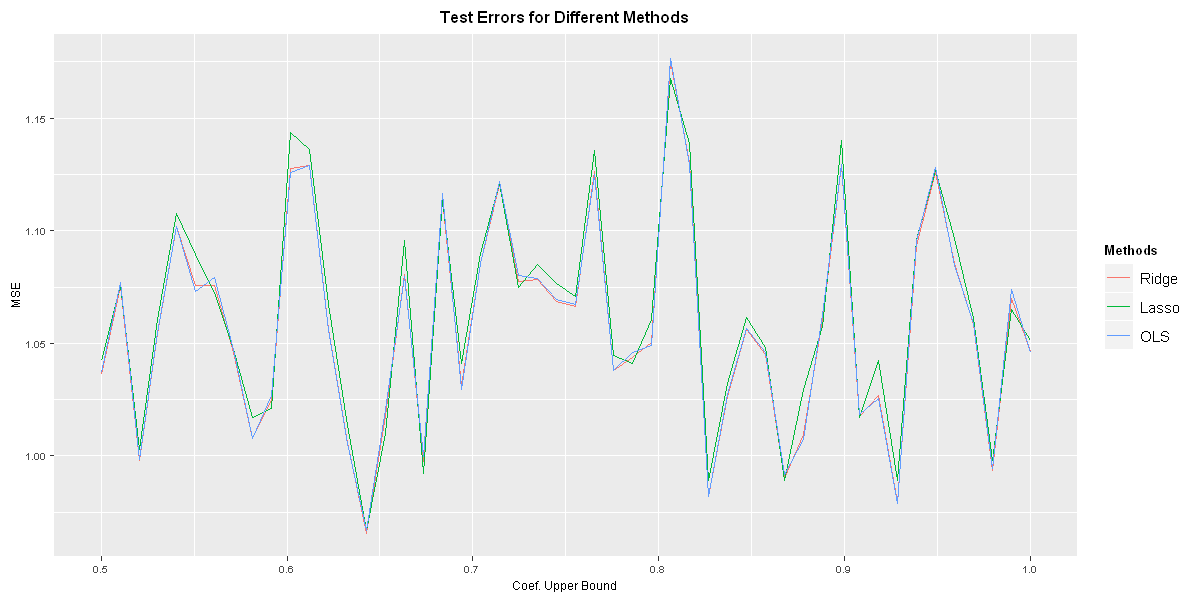

In [123]:
# Prepare the data.frame for plot.
df22 <- data.frame(beta_upper, mses.ridge22, mses.lasso22, mses.ols22)
colnames(df22)[2:4] <- c('Ridge', 'Lasso', 'OLS')
df22.mt <- melt(df22, id.vars='beta_upper', variable.name='Methods')

# Plot
options(repr.plot.width=10, repr.plot.height=5)
p <- ggplot(aes(x=beta_upper, y=value), data=df22.mt) + geom_line(aes(colour=Methods))
p <- p + labs(title='Test Errors for Different Methods', x='Coef. Upper Bound', y='MSE', cex=0.5)
p <- p + theme(plot.title = element_text(hjust = 0.5))
p <- p + theme(axis.text=element_text(size=6), axis.title=element_text(size=7, face='plain'), title=element_text(size=8, face='bold'))
p + scale_fill_discrete(labels=c("Ridge", "Lasso", "OLS"))

# plot(beta_upper, mses.ridge22, type='l', xlab='Beta Upper', ylab='MSE (Test Error)')
# lines(beta_upper, mses.lasso22, col='red')
# lines(beta_upper, mses.ols22, col='blue')
# legend(0.9, 0.96, legend=c('ridge', 'lasso', 'ols'),lty=1:1:1,
#       col=c('black', 'red', 'blue'))